In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import joblib
import numpy as np
import psycopg2
from sqlalchemy import create_engine, text
import json

In [2]:
# PLEASE OPEN JSON FILE create_database_creds.json AND ENTER YOUR CREDENTIALS
with open('create_database_creds.json') as O:
    config = json.load(O)
username = config['user']
password = config['password']
db_host = config['host']
db_port = config['port']
db_ = 'nfl_prediction_data_db'

conn = psycopg2.connect(
    host=db_host,
    port=db_port,
    user=username,
    password=password,
    dbname=db_
)

conn.autocommit = True
cursor = conn.cursor()

query = 'SELECT * FROM nfl_final_data'


master_data = pd.read_sql_query(query, conn)

cursor.close()
conn.close()

In [3]:
master_data.head()

,Rnd,Pick,Player,Pos,AP1,PB,College/Univ,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted_Binary,Pos_encoded,College/Univ_encoded
0,1.0,1.0,Andrew Luck,QB,0.0,1.0,Stanford,76.0,234.0,4.59,36.000000,15.000000,124.000000,6.800000,4.280000,1.0,1,0
1,1.0,3.0,Trent Richardson,RB,0.0,0.0,Alabama,69.0,228.0,4.48,34.626404,18.960000,120.636905,7.038725,4.262870,1.0,2,1
2,1.0,4.0,Matt Kalil,T,0.0,1.0,USC,79.0,306.0,4.96,27.000000,30.000000,105.500000,7.330000,4.650000,1.0,3,2
3,1.0,5.0,Justin Blackmon,WR,0.0,0.0,Oklahoma St.,73.0,207.0,4.46,35.839015,14.000000,122.860465,6.944684,4.222308,1.0,4,3
4,1.0,6.0,Morris Claiborne,DB,0.0,0.0,LSU,71.0,188.0,4.50,34.500000,15.413534,118.000000,7.010000,4.120000,1.0,5,4


In [4]:
master_data.drop(['Player','College/Univ','Pos','Rnd','Pick','AP1','PB'], axis=1, inplace=True)
master_data.head()

,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted_Binary,Pos_encoded,College/Univ_encoded
0,76.0,234.0,4.59,36.000000,15.000000,124.000000,6.800000,4.280000,1.0,1,0
1,69.0,228.0,4.48,34.626404,18.960000,120.636905,7.038725,4.262870,1.0,2,1
2,79.0,306.0,4.96,27.000000,30.000000,105.500000,7.330000,4.650000,1.0,3,2
3,73.0,207.0,4.46,35.839015,14.000000,122.860465,6.944684,4.222308,1.0,4,3
4,71.0,188.0,4.50,34.500000,15.413534,118.000000,7.010000,4.120000,1.0,5,4


In [5]:
master_data.isnull().any()

Ht                      False
Wt                      False
40yd                    False
Vertical                False
Bench                   False
Broad Jump              False
3Cone                   False
Shuttle                 False
Drafted_Binary          False
Pos_encoded             False
College/Univ_encoded    False
dtype: bool

In [6]:
convert_to_int = ['Drafted_Binary']
master_data[convert_to_int] = master_data[convert_to_int].astype(int)
master_data.head()

,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted_Binary,Pos_encoded,College/Univ_encoded
0,76.0,234.0,4.59,36.000000,15.000000,124.000000,6.800000,4.280000,1,1,0
1,69.0,228.0,4.48,34.626404,18.960000,120.636905,7.038725,4.262870,1,2,1
2,79.0,306.0,4.96,27.000000,30.000000,105.500000,7.330000,4.650000,1,3,2
3,73.0,207.0,4.46,35.839015,14.000000,122.860465,6.944684,4.222308,1,4,3
4,71.0,188.0,4.50,34.500000,15.413534,118.000000,7.010000,4.120000,1,5,4


In [7]:
master_data_copy = pd.DataFrame.copy(master_data)
master_data_copy.head(20)

,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted_Binary,Pos_encoded,College/Univ_encoded
0,76.0,234.0,4.59,36.000000,15.000000,124.000000,6.800000,4.280000,1,1,0
1,69.0,228.0,4.48,34.626404,18.960000,120.636905,7.038725,4.262870,1,2,1
2,79.0,306.0,4.96,27.000000,30.000000,105.500000,7.330000,4.650000,1,3,2
3,73.0,207.0,4.46,35.839015,14.000000,122.860465,6.944684,4.222308,1,4,3
4,71.0,188.0,4.50,34.500000,15.413534,118.000000,7.010000,4.120000,1,5,4
5,73.0,213.0,4.54,35.929577,15.413534,123.449275,6.936545,4.190702,1,5,1
6,76.0,221.0,4.65,31.166667,15.000000,112.619048,7.106234,4.322785,1,1,5
7,75.0,242.0,4.58,38.000000,27.000000,123.000000,6.920000,4.120000,1,6,6
8,72.0,190.0,4.38,36.000000,15.000000,123.000000,6.610000,3.940000,1,5,7
9,75.0,346.0,4.89,29.500000,44.000000,105.000000,7.900000,4.560000,1,7,8


In [8]:
X = master_data_copy.drop(columns='Drafted_Binary')
y = master_data_copy['Drafted_Binary']


In [9]:
iso_forest = IsolationForest(contamination=0.01, random_state=20)

iso_forest.fit(X)

anomaly_predictions = iso_forest.predict(X)

anomaly_mask = anomaly_predictions == -1

x_clean = X[~anomaly_mask]
y_clean = y[~anomaly_mask]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x_clean, y_clean, test_size = 0.7, random_state=78)

In [11]:
ocsvm_model = OneClassSVM(nu=0.05)

ocsvm_model.fit(X_train)

anomaly_predictions = ocsvm_model.predict(X)

anomaly_mask = anomaly_predictions == -1

x_clean = X[~anomaly_mask]
y_clean = y[~anomaly_mask]

In [12]:
smote = SMOTE(sampling_strategy='auto', random_state=78)
X_resampled, y_resampled = smote.fit_resample(x_clean, y_clean)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.5, random_state=78)

In [13]:
rf_model = RandomForestClassifier(n_estimators=5000, max_depth=20, random_state=20, class_weight='balanced')

In [14]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=5000,
                       random_state=20)

In [15]:
predictions = rf_model.predict(X_test)

In [16]:
print(classification_report(y_test, predictions,
                            target_names=["Not_Drafted", "Drafted"]))

              precision    recall  f1-score   support

 Not_Drafted       0.97      0.99      0.98      1054
     Drafted       0.99      0.97      0.98      1086

    accuracy                           0.98      2140
   macro avg       0.98      0.98      0.98      2140
weighted avg       0.98      0.98      0.98      2140



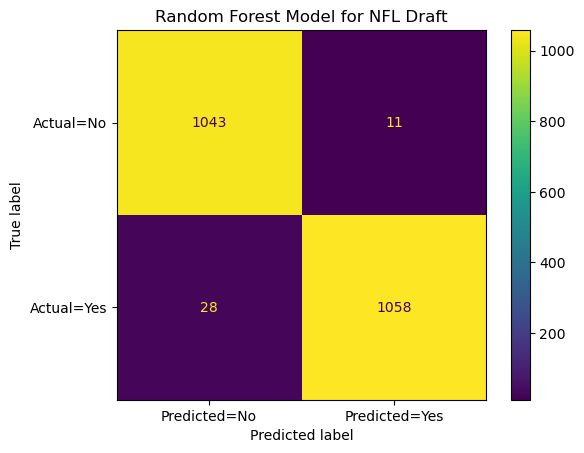

In [17]:
cm = confusion_matrix(y_test, predictions)

true_labels = ["Actual=No", "Actual=Yes"]
predicted_labels = ["Predicted=No", "Predicted=Yes"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.title('Random Forest Model for NFL Draft')
plt.xticks(np.arange(len(predicted_labels)), predicted_labels)
plt.yticks(np.arange(len(true_labels)), true_labels)
plt.show()

In [18]:
test_sample = {
    'Ht': 72.0,
    'Wt': 200,
    '40yd': 4.650000,
    'Vertical': 32,
    'Bench': 17.39726,
    'Broad Jump': 123.737500,
    '3Cone': 6.911795,
    'Shuttle': 4.187000,
    'Pos_encoded': 18,
    'College/Univ_encoded': 2
}

In [19]:
test_df = pd.DataFrame([test_sample])

In [20]:
prediction = rf_model.predict(test_df)

In [21]:
print("Predicted NFL Draft Status:", prediction[0])

Predicted NFL Draft Status: 1


In [22]:
nfl_draft_prediction_model_file = 'nfl_draft_prediction.joblib'
joblib.dump(rf_model, nfl_draft_prediction_model_file)

['nfl_draft_prediction.joblib']